#### LDA and document similarity using [gensim](https://radimrehurek.com/gensim/models/ldamodel.html)

Source [Kaggle](https://www.kaggle.com/code/ktattan/lda-and-document-similarity)

In [1]:
# import dependencies

import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
import gensim
from gensim.models import LdaModel
from gensim import models, corpora, similarities
import re
from nltk.stem.porter import PorterStemmer
import time
from nltk import FreqDist
from scipy.stats import entropy
import matplotlib.pyplot as plt
%matplotlib inline


In [ ]:
# download tokenizer - only need to do this once
# nltk.download("punkt_tab")

In [ ]:
# optional settings for plots
# import seaborn as sns
# sns.set_style("darkgrid")

#### Load data

In [4]:
df = pd.read_csv('descriptions_subset.csv')
print(len(df))
print(df.columns)


11439
Index(['project_id', 'category_url', 'title', 'description'], dtype='object')


#### Define functions to clean and tokenize the data

In [6]:
def initial_clean(text):
    """
    Function to clean text of websites, email addresess and any punctuation
    We also lower case the text
    """
    text = re.sub(r"((\S+)?(http(s)?)(\S+))|((\S+)?(www)(\S+))|((\S+)?(\@)(\S+)?)", " ", text)
    text = re.sub("[^a-zA-Z ]", "", text)
    text = text.lower() # lower case the text
    text = nltk.word_tokenize(text)
    return text

stop_words = stopwords.words('english')
def remove_stop_words(text):
    """
    Function that removes all stopwords from text
    """
    return [word for word in text if word not in stop_words]

stemmer = PorterStemmer()
def stem_words(text):
    """
    Function to stem words, so plural and singular are treated the same
    """
    try:
        text = [stemmer.stem(word) for word in text]
        text = [word for word in text if len(word) > 1] # make sure we have no 1 letter words
    except IndexError: # the word "oed" broke this, so needed try except
        pass
    return text

def apply_all(text):
    """
    This function applies all the functions above into one
    """
    return stem_words(remove_stop_words(initial_clean(text)))

Clean text and title and create new column called "tokenized"

In [7]:
t1 = time.time()
df['tokenized'] = df['description'].apply(apply_all)
t2 = time.time()
print("Time to clean and tokenize", len(df), "articles:", (t2-t1)/60, "min")

Time to clean and tokenize 11439 articles: 1.8802951574325562 min


### Get word frequencies

In [9]:
# first get a list of all words
all_words = [word for item in list(df['tokenized']) for word in item]
# use nltk fdist to get a frequency distribution of all words
fdist = FreqDist(all_words)
len(fdist) # number of unique words

195715

#### Choose k and visually inspect the bottom 10 words of the top k

In [10]:
k = 50000
top_k_words = fdist.most_common(k)
top_k_words[-10:]

[('impacthorror', 2),
 ('moonbut', 2),
 ('twobut', 2),
 ('getter', 2),
 ('challengeslisten', 2),
 ('wald', 2),
 ('discussionsw', 2),
 ('fullyneutr', 2),
 ('debatecon', 2),
 ('perkscurr', 2)]

In [11]:
k = 15000
top_k_words = fdist.most_common(k)
top_k_words[-10:]

[('volleybal', 11),
 ('dresser', 11),
 ('stargaz', 11),
 ('hydroelectr', 11),
 ('poorer', 11),
 ('granular', 11),
 ('ventu', 11),
 ('atyp', 11),
 ('vv', 11),
 ('bronco', 11)]

#### Define a function only to keep words in the top k words

k = 50,000 is too high, as the bottom words aren't even real words and are very rarely used (twice in entire corpus)  
k = 15,000 is much more reasonable as these have been used at least 11 times in the corpus

In [12]:
top_k_words,_ = zip(*fdist.most_common(k))
top_k_words = set(top_k_words)
def keep_top_k_words(text):
    return [word for word in text if word in top_k_words]

In [13]:
df['tokenized'] = df['tokenized'].apply(keep_top_k_words)

#### Check document lengths and for short articles

LDA does not work very well on short documents, but the average document length is about 400 when all stop words are removed and only the top 15,000 words are used.

In [14]:
df['doc_len'] = df['tokenized'].apply(lambda x: len(x))
doc_lengths = list(df['doc_len'])
df.drop(labels='doc_len', axis=1, inplace=True)

print("length of list:",len(doc_lengths),
      "\naverage document length", np.average(doc_lengths),
      "\nminimum document length", min(doc_lengths),
      "\nmaximum document length", max(doc_lengths))

length of list: 11439 
average document length 352.40694116618585 
minimum document length 26 
maximum document length 1171


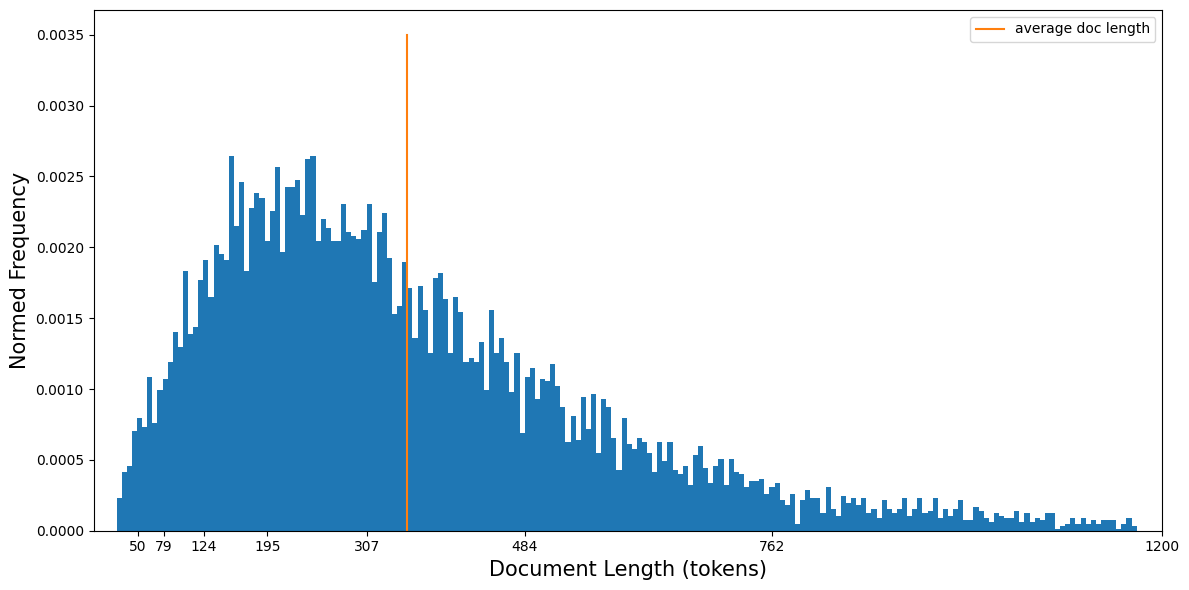

In [17]:
num_bins = 200
fig, ax = plt.subplots(figsize=(12,6));
# the histogram of the data
n, bins, patches = ax.hist(doc_lengths, num_bins, density=True)
ax.set_xlabel('Document Length (tokens)', fontsize=15)
ax.set_ylabel('Normed Frequency', fontsize=15)
ax.grid()
ax.set_xticks(np.logspace(start=np.log10(50),stop=np.log10(1200),num=8, base=10.0))
plt.xlim(0,1200)
ax.plot([np.average(doc_lengths) for i in np.linspace(0.0,0.0035,100)], np.linspace(0.0,0.0035,100), '-',
        label='average doc length')
ax.legend()
ax.grid()
fig.tight_layout()
plt.show()

### Make sure all tokenized items are lists

In [18]:
df = df[df['tokenized'].map(type) == list]
df.reset_index(drop=True,inplace=True)
print("The dataframe has", len(df), "articles")

The dataframe has: 11439 articles


In [27]:
import re
example_description = df.description.iloc[0]
example_description = re.sub('!\\[\\]\\(.*\\)\n', '', example_description)
example_tokens = df.tokenized.iloc[0]

print(example_description)
print(example_tokens)

Lia gently vibrates to remind you to improve your posture throughout the day and tracks your progress to adjust the program based on how fast your posture is improving. The app allows you to monitor your progress and achievements on your journey to better posture!
And if you’ve ever experienced back pain before (which, according to the statistics, you probably already have), you know that gimmicks and braces just don’t work as a long-term solution. As soon as they are removed, you’re apt to fall back into bad posture habits and pain again, which is no way to live.
Habit creation and muscle development must come together in order to have a long-term posture solution. Lia’s AI-powered posture correction platform has changed all that by delivering a combination of gentle reminders, habit creation, and physical muscle training, all in a discrete device worn under your clothes to ensure you are on track to see lasting improvement in your posture.
Using three sensors, Lia gathers detailed da

#### Save the dataframe as csv file

In [30]:
# df.to_csv("dataset_11439_tokens.csv", index=False)

In [28]:
train_df = df

# LDA

Latent Dirichlet Allocation, is an unsupervised generative model that assigns topic distributions to documents.

The model initialises by assigning every word in every document to a **random** topic. Then, we iterate through each word, unassign it's current topic, decrement the topic count corpus wide and reassign the word to a new topic based on the local probability of topic assignemnts to the current document, and the global (corpus wide) probability of the word assignments to the current topic. This may be hard to understand in words, so the equations are below.

### The mathematics of collapsed gibbs sampling (cut back version)

Recall that when we iterate through each word in each document, we unassign its current topic assignment and reassign the word to a new topic. The topic we reassign the word to is based on the probabilities below.

$$
P\left(\text{document "likes" the topic}\right) \times P\left(\text{topic "likes" the word } w'\right)
$$

$$
\Rightarrow \frac{n_{i,k}+\alpha}{N_i-1+K\alpha} \times \frac{m_{w',k}+\gamma}{\sum_{w\in V}m_{w,k} + V\gamma}
$$

where

$n_{i,k}$ - number of word assignments to topic $k$ in document $i$

$n_{i,k}$ - number of assignments to topic $k$ in document $i$

$\alpha$ - smoothing parameter (hyper parameter - make sure probability is never 0)

$N_i$ - number of words in document $i$

$-1$ - don't count the current word you're on

$K$ - total number of topics


$m_{w',k}$ - number of assignments, corpus wide, of word $w'$ to topic $k$

$m_{w',k}$ - number of assignments, corpus wide, of word $w'$ to topic $k$

$\gamma$ - smoothing parameter (hyper parameter - make sure probability is never 0)

$\sum_{w\in V}m_{w,k}$ - sum over all words in vocabulary currently assigned to topic $k$

$V$ size of vocabulary i.e. number of distinct words corpus wide

### Notes about LDA

LDA does not work well with very short documents, like twitter feeds, as explained here [[1]](https://pdfs.semanticscholar.org/f499/5dc2a4eb901594578e3780a6f33dee02dad1.pdf) [[2]](https://stackoverflow.com/questions/29786985/whats-the-disadvantage-of-lda-for-short-texts), which is why we dropped articles under 40 tokens previously. Very briefly, this is because the model infers parameters from observations and if there are not enough observations (words) in a document, the model performs poorly. For short texts, although yet to be rigoursly tested, it may be best to use a [biterm model](https://pdfs.semanticscholar.org/f499/5dc2a4eb901594578e3780a6f33dee02dad1.pdf).

Unlike the word2vec algorithm, which performs extremely well with full structured sentences, LDA is a bag of words model, meaning word order in a document doesnt count. This also means that stopwords and rare words should be excluded, so that the model doesnt overcompensate for very frequent words and very rare words, both of which do not contribute to general topics.

#### Hyperparameters

LDA has 2 hyperparameters: $\alpha$ and $\eta$

$\alpha$ - A low value for $\alpha$ means that documents have only a low number of topics contributing to them. A high value of $\alpha$ yields the inverse, meaning the documents appear more alike within a corpus.

$\eta$ - A low value for $\eta$ means the topics have a low number of contributing words. A high value of $\eta$ yields the inverse, meaning topics will have word overlap and appear more alike.

The values of $\alpha$ and $\eta$ really depend on the application, and may need to be tweaked several times before the desired results are found... even then, LDA is non-deterministic since parameters are randomly initialised, so the outcome of any run of the model can never be known in advance.

    # low alpha means each document is only represented by a small number of topics, and vice versa
    # low eta means each topic is only represented by a small number of words, and vice versa

[source:](https://towardsdatascience.com/topic-modeling-with-latent-dirichlet-allocation-e7ff75290f8)
Fine tuning the 𝛂 and 𝛃 hyperparameters

Based on my experience, generalized for working with any dataset, the guidelines for a heuristic approach are as follows:

    Given knowledge of the topics, is it expected that the distribution of topics in each document will be sparse, such that each document contains only a few topics? If yes, then choose an 𝛂 < 1
    Given knowledge of the total vocabulary, is it expected that the distribution of words in each topic will be sparse, such that certain topics favour certain words? If yes, then choose a 𝛃 < 1

In [40]:
def train_multicore_lda(data):
    """
    This function trains the lda model
    We setup parameters like number of topics, the chunksize to use in Hoffman method 
    """

    dictionary = corpora.Dictionary(data['tokenized'])
    corpus = [dictionary.doc2bow(doc) for doc in data['tokenized']]
    t1 = time.time()

    lda = models.LdaMulticore(corpus=corpus, 
                              num_topics=100, 
                              id2word=dictionary,
                              chunksize=100, 
                              passes = 10,
                              minimum_probability=0.0, 
                              workers=6)  
    
    t2 = time.time()
    print("Time to train LDA model on ", len(df), "articles: ", (t2-t1)/60, "min")
    return dictionary,corpus,lda

In [32]:
# def train_lda(data):
#     """
#     This function trains the lda model
#     We setup parameters like number of topics, the chunksize to use in Hoffman method
#     We also do 2 passes of the data since this is a small dataset, so we want the distributions to stabilize   
#     """
#     num_topics = 100
#     chunksize = 500
#     dictionary = corpora.Dictionary(data['tokenized'])
#     corpus = [dictionary.doc2bow(doc) for doc in data['tokenized']]
#     t1 = time.time()

#     lda = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary,
#                    alpha=1e-2, eta=0.5e-2, chunksize=chunksize, minimum_probability=0.0, passes=2)
    # lda = LdaModel(corpus=corpus, 
    #                num_topics=num_topics, 
    #                id2word=dictionary,
    #                 alpha='auto', 
    #                 eta='auto', 
    #                 chunksize=chunksize, 
    #                 iterations = 400, 
    #                 minimum_probability=0.0, 
    #                 eval_every = None, 
    #                 passes=20)
    
    
    # t2 = time.time()
    # print("Time to train LDA model on ", len(df), "articles: ", (t2-t1)/60, "min")
    # return dictionary,corpus,lda

In [16]:
# def train_lda(data):

#     # https://radimrehurek.com/gensim/auto_examples/tutorials/run_lda.html

#     dictionary = corpora.Dictionary(data['tokenized'])
#     corpus = [dictionary.doc2bow(doc) for doc in data['tokenized']]
#     t1 = time.time()

#     # Set training parameters.
#     num_topics = 100
#     chunksize = 2000
#     passes = 20
#     iterations = 400
#     eval_every = None  # Don't evaluate model perplexity, takes too much time.

#     lda = LdaModel(
#         corpus=corpus,
#         id2word=dictionary,
#         chunksize=chunksize,
#         alpha='auto',
#         eta='auto',
#         iterations=iterations,
#         num_topics=num_topics,
#         passes=passes,
#         eval_every=eval_every
#     )
        
#     t2 = time.time()
#     print("Time to train LDA model on ", len(df), "articles: ", (t2-t1)/60, "min")
#     return dictionary,corpus,lda

In [41]:
# dictionary,corpus,lda = train_lda(train_df)
dictionary,corpus,lda = train_multicore_lda(train_df)

Time to train LDA model on  11439 articles:  7.009587891896566 min


#### Save model and corpus to file

#### Save the corpus, dictionary, and model to file for loading later

In [42]:
# corpora.MmCorpus.serialize('lda_11439_corpus.gensim', corpus)  
# dictionary.save('lda_11439_dictionary.gensim')
# lda.save('lda_11439_model.gensim')

#### Compute coherence score

In [42]:
# Compute Coherence Score
# https://techblog.smc.it/en/2021-10-22/topic-modelling
# https://neptune.ai/blog/pyldavis-topic-modelling-exploration-tool-that-every-nlp-data-scientist-should-know
# https://medium.com/analytics-vidhya/topic-modeling-using-gensim-lda-in-python-48eaa2344920

from gensim.models.coherencemodel import CoherenceModel

coherence_model_lda = CoherenceModel(model=lda, texts=train_df['tokenized'], dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)


Coherence Score:  0.4428303839903848


## Create Table A1 from Taeuscher et al. 2021

In [ ]:
vectors = []
for bow_doc in range(len(corpus)):
    vector1 = lda.get_document_topics(corpus[bow_doc])
    vectors.append(vector1)

# COLUMN 2 - Topic Loading
for current_topic_num in range(100):
    current_topic_total = []
    for bow_doc in range(len(vectors)):
        vector = vectors[bow_doc]
        current_topic_total.append(vector[current_topic_num][1])
    col2_df = pd.DataFrame({'topic_num': [current_topic_num], 'topic_loading_sums': [sum(current_topic_total)]})
    col2_df.to_csv("topics_overview_loadings.csv", mode='a', header=False, index=False)

# Column 3 - Topic weight (%)
for current_topic_num in range(100):
    current_total = 0
    for bow_doc in range(len(vectors)):
        current_total += vectors[bow_doc][current_topic_num][1]
    avg_topic_share =  current_total / len(vectors)
    avg_topic_share = avg_topic_share*100
    avg_topic_share = round(avg_topic_share,1)
    col2_df = pd.DataFrame({'topic_num': [current_topic_num], 'avg_topic_share': [avg_topic_share]})
    col2_df.to_csv("topic_overview_avg_shares.csv", mode='a', header=False, index=False)

# Column 4 - 20 representative words
from collections import Counter
topics = lda.show_topics(formatted=False, num_topics = 100, num_words=20)
data_flat = [w for w_list in corpus for w in w_list]
counter = Counter(data_flat)
test = []
for i, topic in topics:
    for word, weight in topic:
        test.append([word, i , weight, counter[word]])
topic_words_df = pd.DataFrame(test, columns=['word', 'topic_id', 'importance', 'word_count'])
words = topic_words_df['word'].loc[topic_words_df['topic_id']==0].tolist()
topic_words_df.to_csv("topic_overview_top_words.csv", index=False)

#### Inspect topics

C:\Users\gaoan\AppData\Local\Temp\ipykernel_2340\2230205271.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'center')
C:\Users\gaoan\AppData\Local\Temp\ipykernel_2340\2230205271.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'center')
C:\Users\gaoan\AppData\Local\Temp\ipykernel_2340\2230205271.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'center')
C:\Users\gaoan\AppData\Local\Temp\ipykernel_2340\2230205271.py:33: UserWarning: set_ticklabels() should only be used with a 

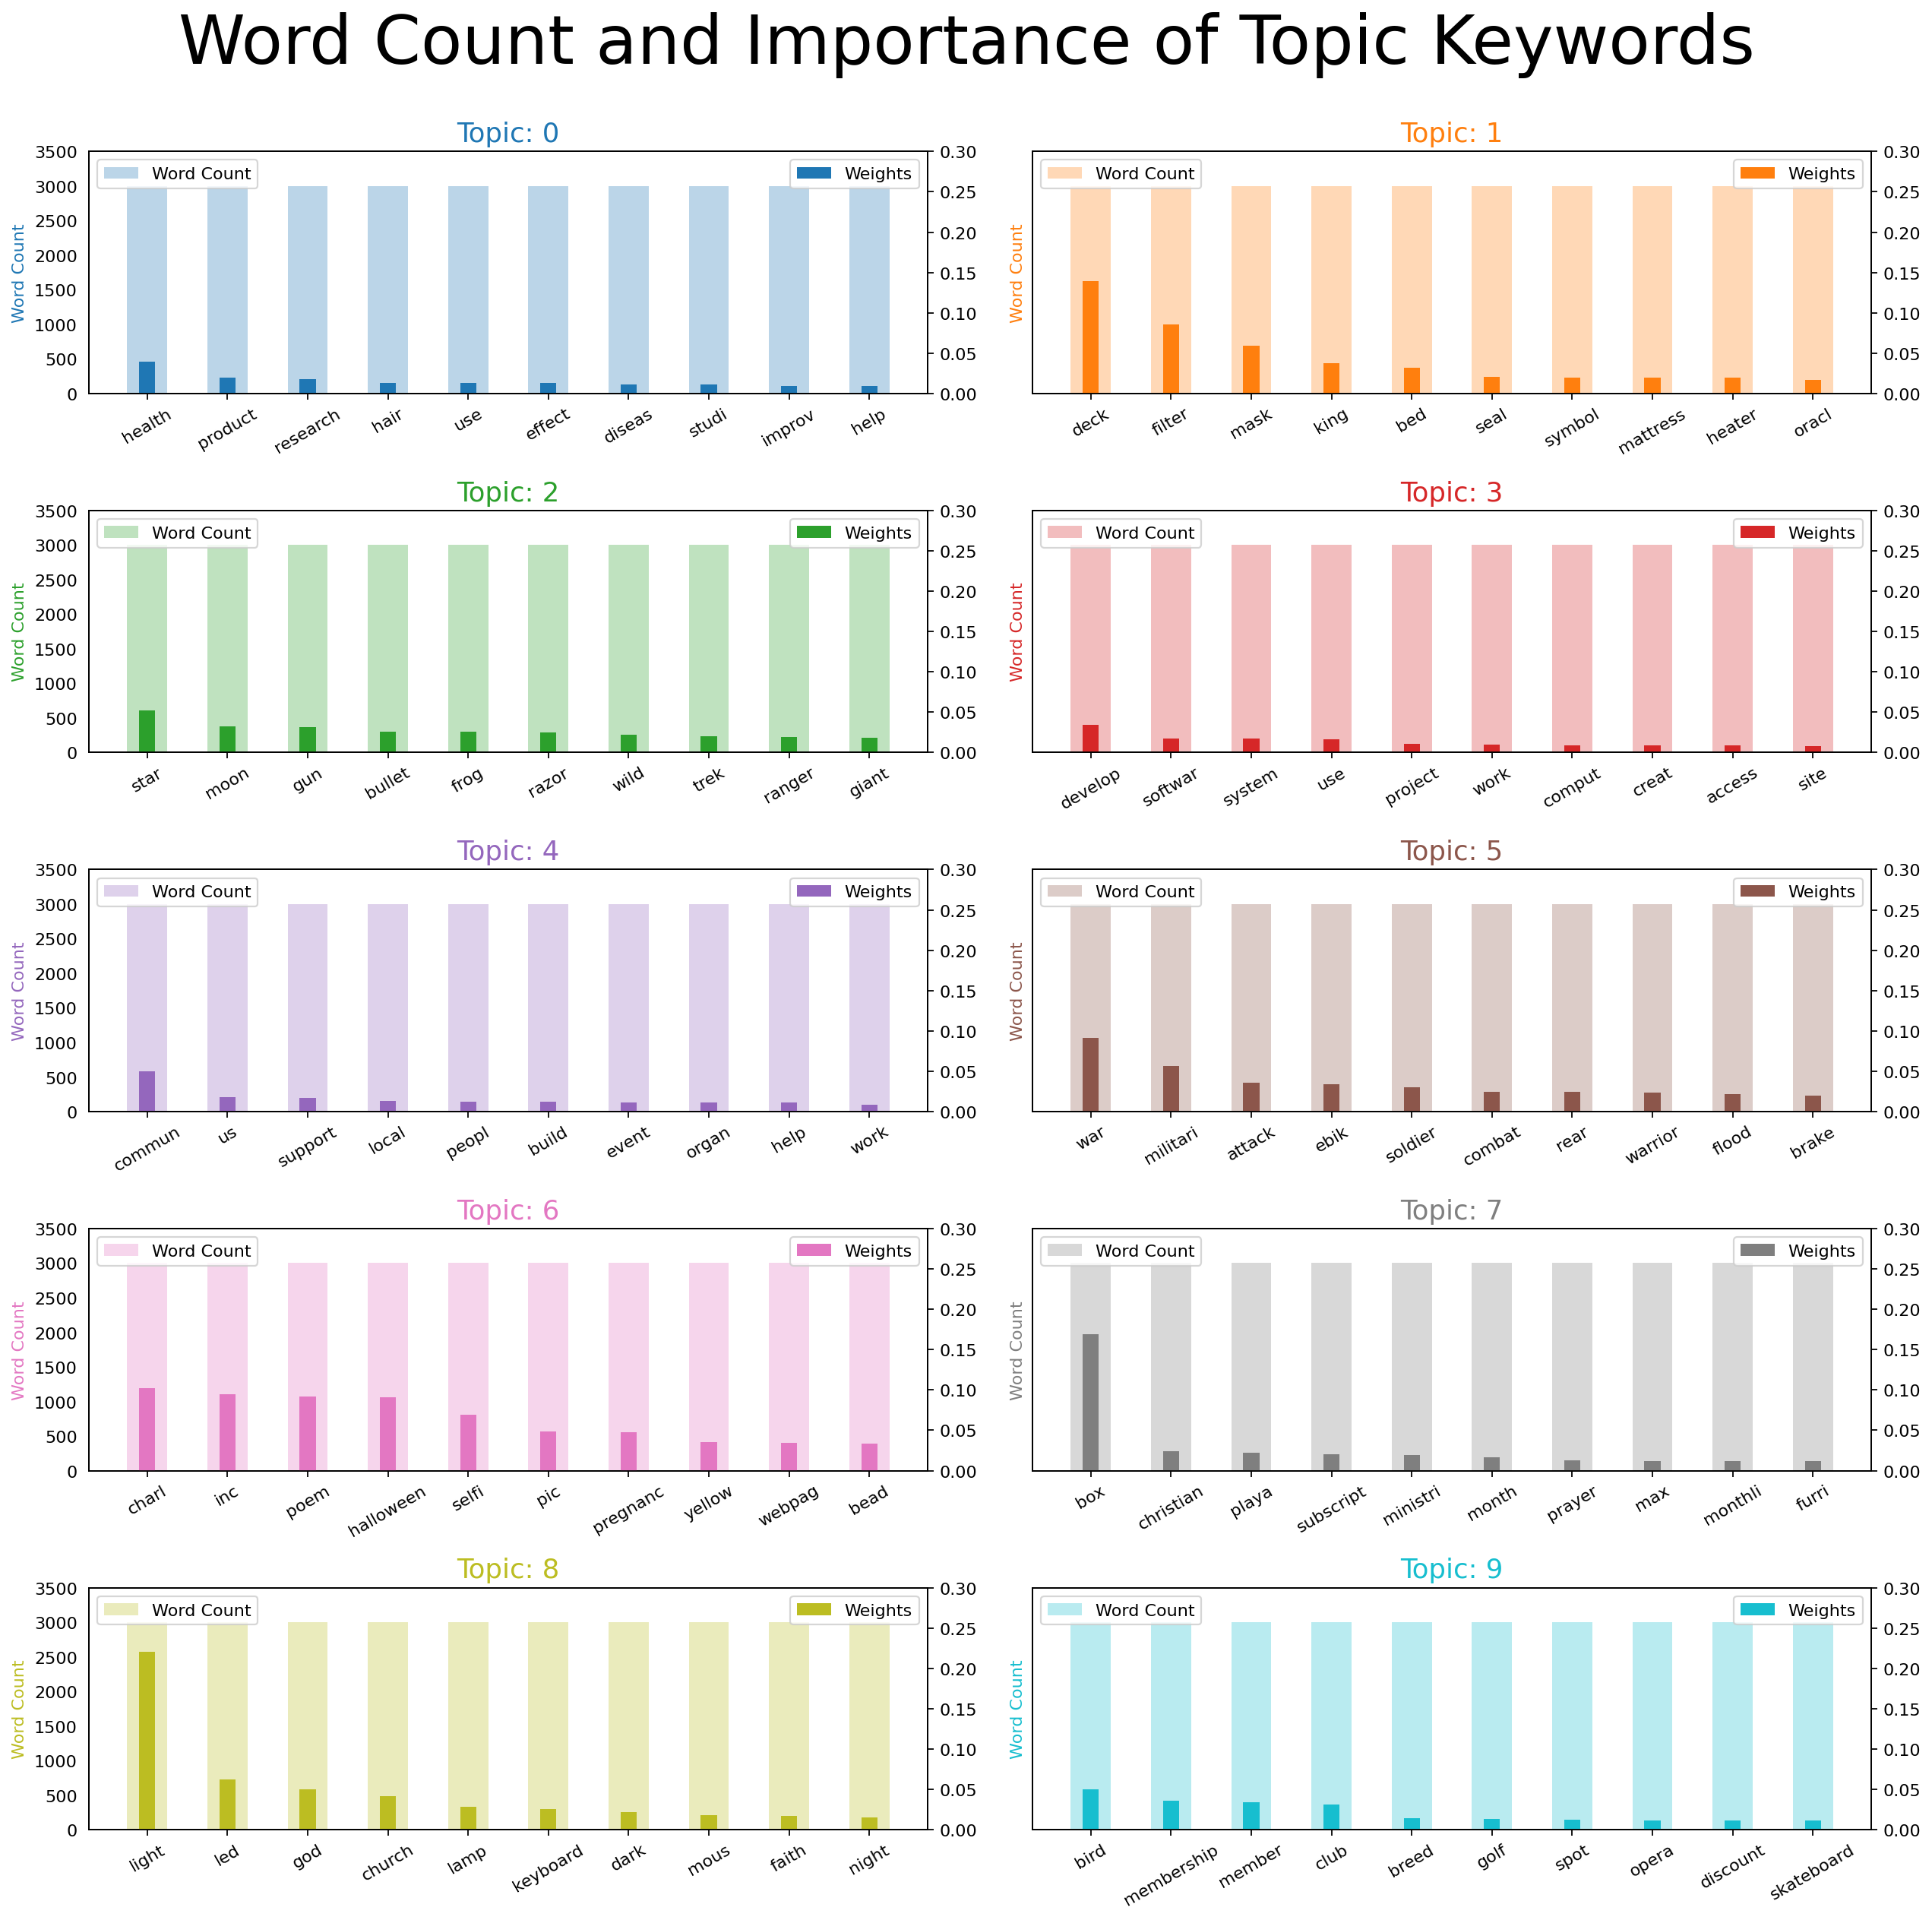

In [43]:

# https://cmotions.nl/en/topic-modeling-with-latent-dirichlet-allocation-lda/

from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
from collections import Counter
%matplotlib inline

lda_model = lda
bow_corpus = corpus

topics = lda_model.show_topics(formatted=False, num_topics = 100)
data_flat = [w for w_list in bow_corpus for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(5, 2, figsize=(16,15), sharey=True, dpi=160) #setting the number of topics visualised 
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height=3000, data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.3); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'center')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=40, y=1.05)    
plt.show()

In [44]:
# show_topics method shows the the top num_words contributing to num_topics number of random topics
lda.show_topics(num_topics=10, num_words=20)

[(36,
  '0.125*"boston" + 0.105*"campu" + 0.084*"button" + 0.063*"cannabi" + 0.054*"reel" + 0.051*"bud" + 0.036*"cider" + 0.033*"headlin" + 0.027*"cesar" + 0.024*"lanyard" + 0.020*"aw" + 0.019*"orchard" + 0.014*"cbd" + 0.014*"caus" + 0.014*"sticker" + 0.013*"recept" + 0.013*"thankyou" + 0.012*"best" + 0.010*"bittersweet" + 0.010*"fanbas"'),
 (17,
  '0.160*"gold" + 0.091*"brick" + 0.062*"atlanta" + 0.051*"pan" + 0.051*"silver" + 0.047*"georgia" + 0.042*"cast" + 0.040*"pit" + 0.031*"bronz" + 0.025*"bull" + 0.022*"issu" + 0.018*"boot" + 0.017*"collar" + 0.015*"color" + 0.015*"db" + 0.014*"wright" + 0.013*"sailor" + 0.013*"carpent" + 0.012*"collect" + 0.011*"seri"'),
 (58,
  '0.186*"cat" + 0.177*"pet" + 0.051*"anim" + 0.026*"adopt" + 0.024*"stray" + 0.024*"dog" + 0.021*"owner" + 0.020*"shelter" + 0.018*"home" + 0.018*"food" + 0.016*"human" + 0.016*"russia" + 0.012*"care" + 0.011*"lover" + 0.010*"find" + 0.009*"veterinarian" + 0.009*"brook" + 0.009*"silli" + 0.009*"locker" + 0.008*"felin"')

#### Infer individual topics

In [45]:
lda.show_topic(topicid=0, topn=20)

[('health', 0.039649315),
 ('product', 0.019521175),
 ('research', 0.0181337),
 ('hair', 0.013082198),
 ('use', 0.012960811),
 ('effect', 0.012915691),
 ('diseas', 0.01119136),
 ('studi', 0.011128576),
 ('improv', 0.009601972),
 ('help', 0.009289248),
 ('brain', 0.009257828),
 ('natur', 0.00895966),
 ('increas', 0.008528433),
 ('lab', 0.008502689),
 ('healthi', 0.007983436),
 ('test', 0.007961209),
 ('medic', 0.00781736),
 ('prevent', 0.0073044864),
 ('chemic', 0.0072796196),
 ('medicin', 0.006651702)]

In [46]:
lda.show_topic(topicid=99, topn=20)

[('sport', 0.08066786),
 ('team', 0.056219544),
 ('athlet', 0.041628856),
 ('chip', 0.027840959),
 ('ceram', 0.024261428),
 ('tournament', 0.022648226),
 ('bridg', 0.021986224),
 ('play', 0.02049024),
 ('player', 0.019933032),
 ('coach', 0.01899118),
 ('copper', 0.016822517),
 ('leagu', 0.01672416),
 ('tokyo', 0.015449425),
 ('foot', 0.014556298),
 ('match', 0.013861171),
 ('clay', 0.012886112),
 ('carpet', 0.012317644),
 ('win', 0.012250091),
 ('basketbal', 0.011878158),
 ('point', 0.011689289)]

#### This topic is about projects

In [47]:
lda.show_topic(topicid=50, topn=20)

[('bike', 0.14251514),
 ('coffe', 0.107576825),
 ('bicycl', 0.038016964),
 ('cup', 0.03162228),
 ('pod', 0.018077793),
 ('ride', 0.01614557),
 ('pedal', 0.015358665),
 ('cycl', 0.015293598),
 ('mug', 0.011873593),
 ('ac', 0.010581088),
 ('roast', 0.008328405),
 ('shop', 0.008274419),
 ('drink', 0.007705285),
 ('cargo', 0.007498675),
 ('ir', 0.0070453607),
 ('bean', 0.006703756),
 ('get', 0.006408972),
 ('hub', 0.005866593),
 ('qi', 0.00573947),
 ('electr', 0.005653823)]

#### Visualize the topic distribution for a random example article

In [56]:
count = 0
for c in train_df.columns:
    print(f"{count}: {c}")
    count+=1

random_article_index = np.random.randint(len(train_df))
bow = dictionary.doc2bow(train_df.iloc[random_article_index,4])

print(random_article_index)
print(train_df.iloc[random_article_index,1])
print(train_df.iloc[random_article_index,2])
print(train_df.iloc[random_article_index,4])

0: project_id
1: category_url
2: title
3: description
4: tokenized
2676
/explore/writing-publishing
Single Mom and the City,  Informative How To Book!
['mom', 'around', 'world', 'book', 'san', 'francisco', 'made', 'singl', 'mom', 'citi', 'money', 'rich', 'life', 'guidebook', 'thrive', 'saniti', 'peac', 'mind', 'book', 'noth', 'kid', 'play', 'stick', 'breast', 'bottl', 'mouth', 'book', 'health', 'well', 'mom', 'time', 'get', 'financi', 'hous', 'order', 'creat', 'incom', 'ultim', 'creat', 'live', 'life', 'want', 'airplan', 'prior', 'take', 'flight', 'attend', 'tell', 'put', 'mask', 'first', 'event', 'emerg', 'better', 'equip', 'help', 'other', 'mom', 'happi', 'healthi', 'entir', 'famili', 'littl', 'mei', 'born', 'rais', 'citi', 'san', 'francisco', 'becam', 'first', 'time', 'mom', 'realli', 'clue', 'often', 'brand', 'new', 'mom', 'tri', 'make', 'creat', 'human', 'littl', 'human', 'use', 'bodi', 'hous', 'month', 'let', 'sink', 'short', 'first', 'becam', 'new', 'mom', 'wish', 'encompass', '

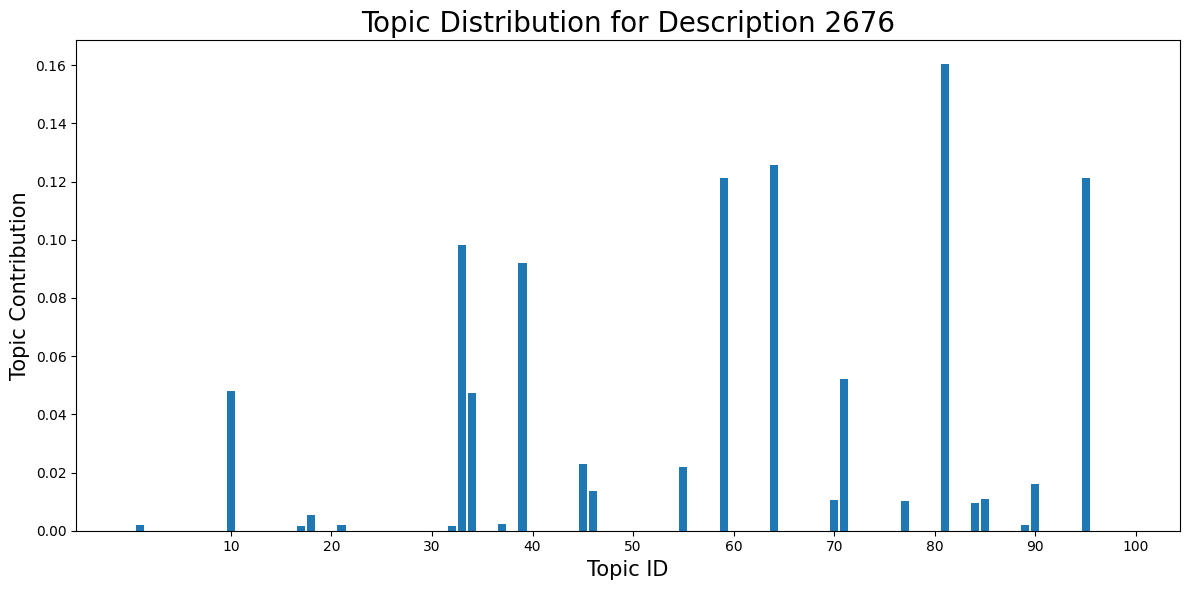

In [57]:
doc_distribution = np.array([tup[1] for tup in lda.get_document_topics(bow=bow)])

fig, ax = plt.subplots(figsize=(12,6));
patches = ax.bar(np.arange(len(doc_distribution)), doc_distribution)
ax.set_xlabel('Topic ID', fontsize=15)
ax.set_ylabel('Topic Contribution', fontsize=15)
ax.set_title("Topic Distribution for Description " + str(random_article_index), fontsize=20)
ax.set_xticks(np.linspace(10,100,10))
fig.tight_layout()
plt.show()

#### Inspect article's top 5 contributing topics and the 10 most relevant words for each topic

In [58]:
for i in doc_distribution.argsort()[-5:][::-1]:
    print(i, lda.show_topic(topicid=i, topn=10), "\n")

81 [('children', 0.12416501), ('kid', 0.06422225), ('child', 0.045100085), ('parent', 0.037245274), ('famili', 0.03349302), ('mother', 0.022203652), ('young', 0.022036599), ('learn', 0.019808007), ('adult', 0.018036656), ('age', 0.017846905)] 

64 [('get', 0.018546624), ('make', 0.01649295), ('help', 0.014995704), ('want', 0.013679154), ('need', 0.011564644), ('peopl', 0.010797124), ('like', 0.0107348915), ('go', 0.010459356), ('time', 0.00998669), ('one', 0.0096746525)] 

59 [('help', 0.02016585), ('donat', 0.015122499), ('famili', 0.014522433), ('peopl', 0.014233902), ('need', 0.014170889), ('provid', 0.012510286), ('live', 0.010928779), ('support', 0.01020216), ('care', 0.009018351), ('commun', 0.00804829)] 

95 [('book', 0.28953934), ('publish', 0.05344533), ('copi', 0.040214803), ('print', 0.034383345), ('page', 0.02463345), ('stori', 0.024210915), ('read', 0.023684833), ('edit', 0.018949691), ('author', 0.015881542), ('sign', 0.015608465)] 

33 [('help', 0.02970651), ('campaign',

### Similarity

We can compare the topic distributions of a document to all the other topic distributions of the documents in the same category. 

We can use the [Jensen-Shannon distance](https://en.wikipedia.org/wiki/Jensen%E2%80%93Shannon_divergence) metric to find the most similar documents.

What the Jensen-Shannon distance tells us, is which documents are statisically "closer" (and therefore more similar), by comparing the divergence of their distributions. Jensen-Shannon is symmetric, unlike Kullback-Leibler on which the formula is based. This is good, because we want the similarity between documents A and B to be the same as the similarity between B and A.

The formula is described below.

For discrete distirbutions $P$ and $Q$, the Jensen-Shannon divergence, $JSD$ is defined as

$$JSD\left(P||Q\right) = \frac{1}{2}D\left(P||M\right)+\frac{1}{2}D\left(Q||M\right)$$

where $M = \frac{1}{2}\left(P+Q\right)$

and $D$ is the Kullback-Leibler divergence

$$D\left(P||Q\right) = \sum_iP(i)\log\left(\frac{P(i)}{Q(i)}\right)$$

$$\Rightarrow JSD\left(P||Q\right) = \frac{1}{2}\sum_i
\left[
P(i)\log\left(\frac{P(i)}{\frac{1}{2}\left(P(i)+Q(i)\right)}\right)
+
Q(i)\log\left(\frac{Q(i)}{\frac{1}{2}\left(P(i)+Q(i)\right)}\right)
\right]$$

The square root of the Jensen-Shannon divergence is the Jensen-Shannon Distance: $\sqrt{JSD\left ( P||Q\right )}$

**The smaller the Jensen-Shannon Distance, the more similar two distributions are (and in our case, the more similar any 2 documents are)**

We can use the scipy implementation of entropy to do this. Entropy calculates the KL divergence.

But first, we need to get all our LDA topic distributions into a dense matrix. This will enable fast and efficient computation.

We will create a dense matrix, **doc_topic_dist**, of size $M\times K$ where $M$ is the number of documents and $K$ is the number of topics.

In [59]:
# we need to use nested list comprehension here
# this may take 1-2 minutes...
doc_topic_dist = np.array([[tup[1] for tup in lst] for lst in lda[corpus]])
doc_topic_dist.shape

(11439, 100)

In [62]:
def jensen_shannon(query, matrix):
    """
    This function implements a Jensen-Shannon similarity
    between the input query (an LDA topic distribution for a document)
    and the entire corpus of topic distributions.
    It returns an array of length M where M is the number of documents in the corpus
    """
    # lets keep with the p,q notation above
    p = query[None,:].T # take transpose
    q = matrix.T # transpose matrix
    m = 0.5*(p + q)
    return np.sqrt(0.5*(entropy(p,m) + entropy(q,m)))

#### Query time

Let's compare the new unseen document, to the corpus, and see how similar it is to all other descriptions.

We are comparing the new unseen document above to the entire corpus of ~21k documents to find all similarities.

Then we are taking the mean of all similarity scores.

How are we doing that? Well, we have the new documents LDA topic distribution in stored as varibale **new_doc_distribution**, and we have the entire corpus of documents topic distributions stored in the dense matrix **doc_topic_dist**. So now, we pass each row of **doc_topic_dist** through the Jensen-Shannon function above as the Q distribution, while the P distribution remains static as **new_doc_distribution**. Then we get the smallest distances and their corresponding index in the array, which we can pass to the **train_df** dataframe to print out the mean similarity to all other documents.

In [60]:
def get_all_similarities_documents(query,matrix,k=10):
    """
    This function implements the Jensen-Shannon distance above
    and retruns the top k indices of the smallest jensen shannon distances
    """
    sims = jensen_shannon(query,matrix) # list of jensen shannon distances
    return sims.argsort()[:k] # the top k positional index of the smallest Jensen Shannon distances

In [65]:
get_all_similarities_documents(doc_distribution,doc_topic_dist)


array([2676, 2444, 2768, 2309, 2621, 2520, 2544, 2430, 2343, 1549],
      dtype=int64)

In [67]:
print(random_article_index)
print(train_df.iloc[random_article_index,1])
print(train_df.iloc[random_article_index,2])
print(train_df.iloc[random_article_index,4])

similar_article_index = 2768

print(similar_article_index)
print(train_df.iloc[similar_article_index,1])
print(train_df.iloc[similar_article_index,2])
print(train_df.iloc[similar_article_index,4])

2676
/explore/writing-publishing
Single Mom and the City,  Informative How To Book!
['mom', 'around', 'world', 'book', 'san', 'francisco', 'made', 'singl', 'mom', 'citi', 'money', 'rich', 'life', 'guidebook', 'thrive', 'saniti', 'peac', 'mind', 'book', 'noth', 'kid', 'play', 'stick', 'breast', 'bottl', 'mouth', 'book', 'health', 'well', 'mom', 'time', 'get', 'financi', 'hous', 'order', 'creat', 'incom', 'ultim', 'creat', 'live', 'life', 'want', 'airplan', 'prior', 'take', 'flight', 'attend', 'tell', 'put', 'mask', 'first', 'event', 'emerg', 'better', 'equip', 'help', 'other', 'mom', 'happi', 'healthi', 'entir', 'famili', 'littl', 'mei', 'born', 'rais', 'citi', 'san', 'francisco', 'becam', 'first', 'time', 'mom', 'realli', 'clue', 'often', 'brand', 'new', 'mom', 'tri', 'make', 'creat', 'human', 'littl', 'human', 'use', 'bodi', 'hous', 'month', 'let', 'sink', 'short', 'first', 'becam', 'new', 'mom', 'wish', 'encompass', 'book', 'guid', 'incred', 'yet', 'challeng', 'journey', 'call', 'mot